In [125]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ddm.models
from ddm import Sample
from itertools import product
from IPython.display import display
from ddm import Model, Fittable
from ddm.functions import fit_adjust_model, display_model
from ddm.models import NoiseConstant, BoundConstant, OverlayChain, OverlayNonDecision, OverlayPoissonMixture
import ddm.plot
from copy import deepcopy

## Load and Clean Data
We exlcude
1. Trials with coherence over 0.2
2. Trials with rt under 0.1
3. Trials with invalid rt

In [76]:
# Read Data
columns =['subject', 'noise_color', 'trial', 'noise_trial', 'session', 'coherence', 'correct', 'rt']
data = pd.read_csv('allData.txt', header = None, names=columns)
data['subject'] = [sub.split('_')[2][-6:] for sub in data['subject']]

# Choose only Subject with real Stimulation 
data = data.loc[(data['noise_color']=='white') | (data['noise_color']=='pink') | (data['noise_color']=='blue')]

# Exclude Trials with invalid Reaction Time and reaction times lower than 0.1
data = data[~data['rt'].isnull()]
print('All Valid: ', ~np.any(data.isnull()))
data = data[(data['rt']>0.1) & data['rt']<2.0]

# Exlude Trials with Coherence Levels higher than 200 and reset coherence to percent
data = data[data['coherence']<=200]
data['coherence'] /= 1000

# Get Subject List
SubjectList = np.unique(data['subject'])
print('Subjects: ', SubjectList)
display(data)

All Valid:  True
Subjects:  ['LAB001' 'LAB002' 'LAB004' 'LAB006' 'LAB008' 'LAB011' 'LAB014']


,subject,noise_color,trial,noise_trial,session,coherence,correct,rt
4,LAB001,white,5,5,1,0.200,1,0.58316
5,LAB001,white,6,6,1,0.100,1,0.98299
6,LAB001,white,7,7,1,0.050,1,1.16623
7,LAB001,white,8,8,1,0.025,0,1.21622
8,LAB001,white,9,9,1,0.025,0,0.59975
...,...,...,...,...,...,...,...,...
46151,LAB014,blue,916,240,4,0.015,1,1.11630
46152,LAB014,blue,917,241,4,0.023,0,1.54950
46153,LAB014,blue,918,242,4,0.028,0,1.36621
46154,LAB014,blue,919,243,4,0.045,1,1.28290


## Single Subject Example - White Noise
## Load Data into pyddm

In [100]:
# Subject Lab001 dfs with different Noise colors
white_df = data.loc[(data['noise_color']=='white')  & (data['subject']=='LAB001'), ['correct', 'rt', 'coherence']]
white_sample = Sample.from_pandas_dataframe(white_df, rt_column_name="rt", correct_column_name="correct")

blue_df = data.loc[(data['noise_color']=='blue')  & (data['subject']=='LAB001'), ['correct', 'rt', 'coherence']]
blue_sample = Sample.from_pandas_dataframe(blue_df, rt_column_name="rt", correct_column_name="correct")

pink_df = data.loc[(data['noise_color']=='pink')  & (data['subject']=='LAB001'), ['correct', 'rt', 'coherence']]
pink_sample = Sample.from_pandas_dataframe(pink_df, rt_column_name="rt", correct_column_name="correct")

print('Example Sample - White Noise')
display(white_df)

Example Sample - White Noise


,correct,rt,coherence
4,1,0.58316,0.200
5,1,0.98299,0.100
6,1,1.16623,0.050
7,0,1.21622,0.025
8,0,0.59975,0.025
...,...,...,...
33970,1,1.46624,0.033
33971,0,1.98258,0.017
33973,0,1.73272,0.017
33975,0,1.54942,0.025


## Set up Drift Diffusion Model

In [ ]:
class DriftCoherence(ddm.models.Drift):
    name = "Drift depends linearly on coherence"
    # Parameter that should be included in the ddm
    required_parameters = ["driftcoherence"] 
    # Task Parameter, i.e. coherence
    required_conditions = ["coherence"] 
    
    # Define the get_drift function
    def get_drift(self, conditions, **kwargs):
        return self.driftcoherence * conditions['coherence']

# Set up Model with Drift depending on Coherence
model = Model(name='Noise Model - Drift varies with coherence',
             drift=DriftCoherence(driftcoherence=Fittable(minval=0, maxval=20)),
             noise=NoiseConstant(noise=1),
             bound=BoundConstant(B=Fittable(minval=.1, maxval=1.5)),
             overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.4)),
                                            OverlayPoissonMixture(pmixturecoef=.02,
                                                                  rate=1)]),
            dx=.1, dt=.01, T_dur=2)

## Fit Model

In [132]:
fit_adjust_model(sample=white_sample, model=model, verbose=False)
white_fit = deepcopy(model)
fit_model_blue = fit_adjust_model(sample=blue_sample, model=model, verbose=False)
blue_fit = deepcopy(model)
fit_model_pink = fit_adjust_model(sample=pink_sample, model=model, verbose=False)
pink_fit = deepcopy(model)

differential_evolution step 1: f(x)= 869.126
differential_evolution step 2: f(x)= 869.126
differential_evolution step 3: f(x)= 869.126
differential_evolution step 4: f(x)= 869.126
differential_evolution step 5: f(x)= 865.943
differential_evolution step 6: f(x)= 865.563
differential_evolution step 7: f(x)= 864.418
differential_evolution step 8: f(x)= 863.98
Params [11.5621704   0.98655168  0.36727745] gave 863.9200413558721
differential_evolution step 1: f(x)= 947.429
differential_evolution step 2: f(x)= 945.204
differential_evolution step 3: f(x)= 945.204
differential_evolution step 4: f(x)= 945.204
differential_evolution step 5: f(x)= 945.204
differential_evolution step 6: f(x)= 944.286
differential_evolution step 7: f(x)= 944.286
Params [13.75014464  0.95661355  0.34750456] gave 944.1537211740159
differential_evolution step 1: f(x)= 997.348
differential_evolution step 2: f(x)= 979.766
differential_evolution step 3: f(x)= 979.766
differential_evolution step 4: f(x)= 979.766
differenti

## Plot Model Fits

Model Noise Model - Drift varies with coherence information:
Drift component DriftCoherence:
    Drift depends linearly on coherence
    Fitted parameters:
    - driftcoherence: 11.562170
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundConstant:
    constant
    Fitted parameters:
    - B: 0.986552
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.367277
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixturecoef: 0.020000
        - rate: 1.000000
Fit information:
    Loss function: Negative log likelihood
    Loss function value: 863.9200413558721
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
      

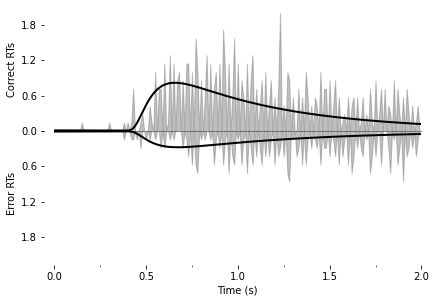

In [139]:
display_model(white_fit)
ddm.plot.plot_fit_diagnostics(model=white_fit, sample=white_sample)

Model Noise Model - Drift varies with coherence information:
Drift component DriftCoherence:
    Drift depends linearly on coherence
    Fitted parameters:
    - driftcoherence: 13.750145
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundConstant:
    constant
    Fitted parameters:
    - B: 0.956614
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.347505
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixturecoef: 0.020000
        - rate: 1.000000
Fit information:
    Loss function: Negative log likelihood
    Loss function value: 944.1537211740159
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
      

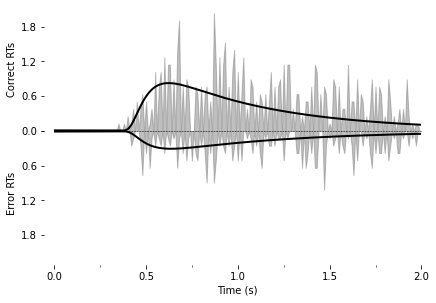

In [140]:
display_model(blue_fit)
ddm.plot.plot_fit_diagnostics(model=blue_fit, sample=blue_sample)

Model Noise Model - Drift varies with coherence information:
Drift component DriftCoherence:
    Drift depends linearly on coherence
    Fitted parameters:
    - driftcoherence: 13.706157
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundConstant:
    constant
    Fitted parameters:
    - B: 0.937576
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.342758
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixturecoef: 0.020000
        - rate: 1.000000
Fit information:
    Loss function: Negative log likelihood
    Loss function value: 974.257710665241
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
       

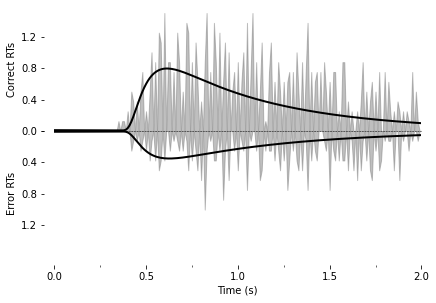

In [142]:
display_model(pink_fit)
ddm.plot.plot_fit_diagnostics(model=pink_fit, sample=pink_sample)